In [2]:
!pip install matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

from datasets_gen import get_mnist_
from noise_scheduler import noise_scheduler,get_at,get_cifar10
import unet

100%|██████████| 9912422/9912422 [00:00<00:00, 33330990.71it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66741429.10it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8931752.12it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4266635.78it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [4]:
Device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
im_data=get_mnist_(normalize=True)
im_data = F.pad(im_data, (1, 2, 1, 2), mode='constant', value=-1)
im_data=im_data.unsqueeze(1)
im_tensor=TensorDataset(im_data,im_data)
trainloader= DataLoader(im_tensor,batch_size=128,shuffle=True)
trainloader=get_cifar10(normalize=True,device='cpu',size=31)

100%|██████████| 170498071/170498071 [00:07<00:00, 22424765.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [23]:
model=unet.Unet(3,64)
model=model.to(Device)
optim=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=F.mse_loss

In [34]:
# Set the number of epochs
num_epochs = 50
loss_list=[]

for epoch in range(num_epochs):
    count=0
    total_loss=0
    for images,_ in trainloader:
        images = images.to(Device)
        b,f,c,c=images.shape
        t=random.randint(0,1000)
        noise=torch.randn(b,f,c,c).to(Device)
        
        noised_image = noise_scheduler(images,noise,t)
        pred_noise=model(noised_image,t)
        loss = criterion(pred_noise,noise)

        count+=1
        total_loss+=loss.item()
        
        loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()
    

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg_Loss: {total_loss/count:.4f}, Sum_loss:{total_loss:.4f}")

Epoch [1/50], Avg_Loss: 0.0753, Sum_loss:58.8719
Epoch [2/50], Avg_Loss: 0.0744, Sum_loss:58.1490
Epoch [3/50], Avg_Loss: 0.0727, Sum_loss:56.8828
Epoch [4/50], Avg_Loss: 0.0798, Sum_loss:62.3809
Epoch [5/50], Avg_Loss: 0.0743, Sum_loss:58.1249
Epoch [6/50], Avg_Loss: 0.0699, Sum_loss:54.6841
Epoch [7/50], Avg_Loss: 0.0729, Sum_loss:57.0056
Epoch [8/50], Avg_Loss: 0.0757, Sum_loss:59.2029


KeyboardInterrupt: 

In [35]:
def DDPM_sampler(model,images,t,n=0.5):
  with torch.no_grad():
      model.eval()
      shape=images.shape
      pred_noise=model(images,t)
      at=get_at(t)
      at1=get_at(t-1)
      base_at=at/at1
      c=(1-base_at)/(math.sqrt(1-at))
      var=(1-base_at)*((1-at1)/(1-at))
      var=(1-base_at)

      if t>1:
        pred_image=math.sqrt(1/(base_at))*torch.clamp((images-c*pred_noise),-1,1) + torch.randn(shape,device=Device)*math.sqrt(var)
        #pred_image=torch.clamp(math.sqrt(1/(base_at))*(images-c*pred_noise),-1,1) + torch.randn(shape,device=Device)*math.sqrt(var)

      else:
        pred_image=math.sqrt(1/(base_at))*(images-c*pred_noise)

      return pred_image

In [36]:
def DDIM_sampler(model,images,t,n=1):
    with torch.no_grad():
        model.eval()
        shape=images.shape
        pred_noise=model(images,t)
        at=get_at(t)
        at1=get_at(t-1)
        pred_x0=(torch.clamp((images-math.sqrt(1-at)*pred_noise)/math.sqrt(at),-1,1))
        #pred_x0=(images-math.sqrt(1-at)*pred_noise)/math.sqrt(at)

        if t>1:
          sigma=n*((1-at1)/(1-at))*(1-(at/at1))
          dir_xt=math.sqrt(1-at1-sigma)*pred_noise
          random_noise=torch.randn(shape,device=Device)*math.sqrt(sigma)
          images=pred_x0*math.sqrt(at1)+dir_xt+random_noise

        else:
          images=(images-math.sqrt(1-at)*pred_noise)/math.sqrt(at)

        return images

In [13]:
def new_sampler(model,images,t):
    with torch.no_grad():
      model.eval()
      shape=images.shape
      pred_noise=model(images,t)
      at=get_at(t)
      at1=get_at(t-1)
      sigma=((1-at1)/(1-at))*(1-(at/at1))
      dir_xt=math.sqrt(1-at1-sigma)*pred_noise
      pred_x0=torch.clamp(((images-math.sqrt(1-at)*pred_noise)/math.sqrt(at)),-1,1)
      noised_image=noise_scheduler(images,pred_noise,t-1)
      return noised_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

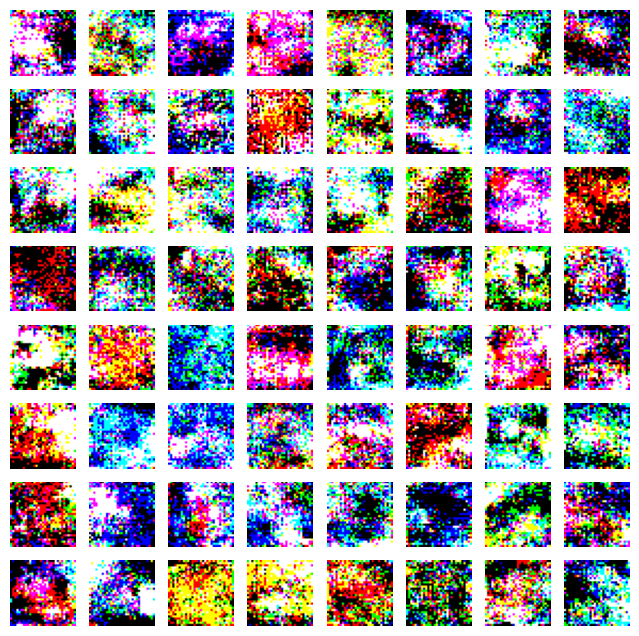

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

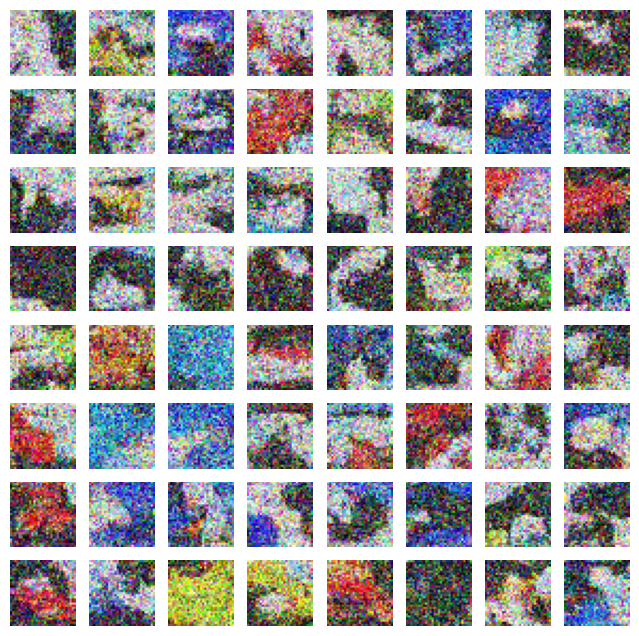

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

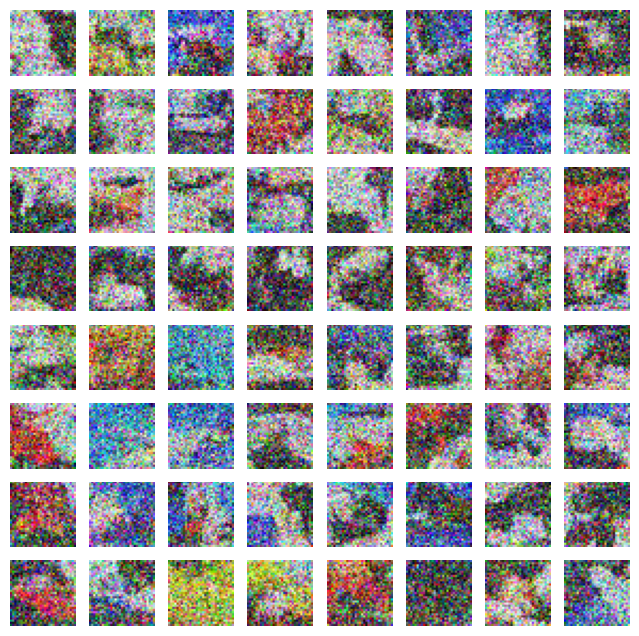

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

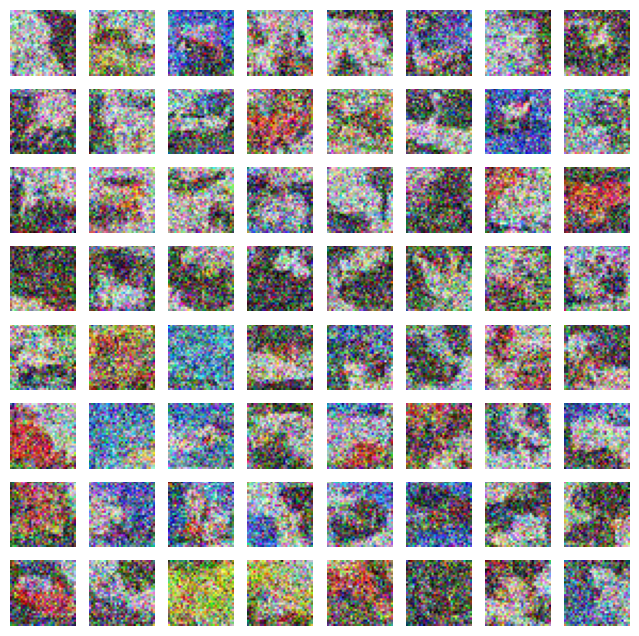

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [ ]:
def data_visualizer(x,save=False,b=8):
  x=x.detach().to('cpu')
  x=x*0.5+0.5
  #print(x)
  #x=torch.clamp(x,-1,1)
  #print(x)
  b,d,c,c=x.shape
  b=int(math.sqrt(b))
  if d!=1:
    x=x.permute(0,2,3,1)
    x=x.view(b,b,c,c,d)
  else:
    x=x.view(b,b,c,c)
  x = x.numpy()
  fig, axes = plt.subplots(b, b, figsize=(b, b))
  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(x[i,j])  # Normalize pixel values to [0, 1]
          axes[i, j].axis('off') 
  if save:
    plt.savefig('samples.jpeg')
  plt.show()
  return

x=torch.randn(128,3,31,31).to(Device)
timesteps=1000
for i in range(0,timesteps):
    t=timesteps-i
    x=DDPM_sampler(model,x,t)
    #x=torch.clamp(x,-1.3,1.3)
        
    if(t%100==0):
        y = x[:64]
        data_visualizer(y)

y = x[:64]
data_visualizer(y,save=True)